In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications.resnet import ResNet50

In [ ]:
#from tensorflow.keras.mixed_precision import experimental as mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

NameError: name 'mixed_precision' is not defined

In [ ]:
train_dir = "F:/sc/chest_xray/train"
validation_dir = "F:/sc/chest_xray/val"
#test_dir = "C:/Users/DELL/Desktop/Brain/Data/small/test"
test_dir = "F:/sc/chest_xray/test"


In [ ]:
model1 = ResNet50(include_top=False,input_shape=(224, 224, 3), weights='imagenet')

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
input_shape = (224,224)

In [ ]:
datagen_train = ImageDataGenerator(rescale=1./255,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=True,
                                  vertical_flip=False)


datagen_test = ImageDataGenerator(rescale=1./255)


batch_size = 8
generator_train = datagen_train.flow_from_directory(directory=train_dir,
                                                    target_size=input_shape,
                                                    batch_size=batch_size,
                                                    shuffle=True)

generator_test = datagen_test.flow_from_directory(directory=test_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)


Found 4686 images belonging to 2 classes.
Found 586 images belonging to 2 classes.


In [ ]:
print(model1.summary())

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
def print_layer_trainable():
    for layer in model1.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))


print_layer_trainable()

True:	input_1
True:	conv1_pad
True:	conv1_conv
True:	conv1_bn
True:	conv1_relu
True:	pool1_pad
True:	pool1_pool
True:	conv2_block1_1_conv
True:	conv2_block1_1_bn
True:	conv2_block1_1_relu
True:	conv2_block1_2_conv
True:	conv2_block1_2_bn
True:	conv2_block1_2_relu
True:	conv2_block1_0_conv
True:	conv2_block1_3_conv
True:	conv2_block1_0_bn
True:	conv2_block1_3_bn
True:	conv2_block1_add
True:	conv2_block1_out
True:	conv2_block2_1_conv
True:	conv2_block2_1_bn
True:	conv2_block2_1_relu
True:	conv2_block2_2_conv
True:	conv2_block2_2_bn
True:	conv2_block2_2_relu
True:	conv2_block2_3_conv
True:	conv2_block2_3_bn
True:	conv2_block2_add
True:	conv2_block2_out
True:	conv2_block3_1_conv
True:	conv2_block3_1_bn
True:	conv2_block3_1_relu
True:	conv2_block3_2_conv
True:	conv2_block3_2_bn
True:	conv2_block3_2_relu
True:	conv2_block3_3_conv
True:	conv2_block3_3_bn
True:	conv2_block3_add
True:	conv2_block3_out
True:	conv3_block1_1_conv
True:	conv3_block1_1_bn
True:	conv3_block1_1_relu
True:	conv3_block1

In [ ]:
transfer_layer = model1.get_layer('conv5_block3_out')
conv_model = Model(inputs=model1.input, outputs=transfer_layer.output)

In [ ]:
from tensorflow.keras.models import Sequential
#for layer in conv_model.layers:
#    layer.trainable = False
    
# Start a new Keras Sequential model.
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
#new_model.add(Sequential(tf.keras.layers.Dense(3))) 
new_model.add(conv_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.

new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))
new_model.add(Dense(512, activation='relu'))
# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
#new_model.add(Dense(512, activation='relu'))


# Add the final layer for the actual classification.
new_model.add(Dense(2, activation='softmax'))

In [ ]:
optimizer = Adam(lr=1e-5)
loss = 'binary_crossentropy'
metrics = ['categorical_accuracy']
#name="binary_crossentropy"
#metrics=[tf.keras.metrics.BinaryAccuracy(),
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(), metrics=metrics)

C:\Users\Lenovo\AppData\Roaming\Python\Python39\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
steps_per_epoch = generator_train.n / batch_size
steps_test = generator_test.n / batch_size

In [ ]:
history = new_model.fit_generator(generator=generator_train,
                                  epochs=30,
                                  steps_per_epoch=steps_per_epoch,
                                  validation_data=generator_test,
                                  validation_steps=steps_test)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10640\4032935994.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = new_model.fit_generator(generator=generator_train,


Epoch 1/30
585/585 [==============================] - 2538s 4s/step - loss: 0.1858 - categorical_accuracy: 0.9321 - val_loss: 6.1457 - val_categorical_accuracy: 0.6212
Epoch 2/30
585/585 [==============================] - 2236s 4s/step - loss: 0.0962 - categorical_accuracy: 0.9682 - val_loss: 4.2605 - val_categorical_accuracy: 0.6246
Epoch 3/30
585/585 [==============================] - 3149s 5s/step - loss: 0.0765 - categorical_accuracy: 0.9772 - val_loss: 1.1684 - val_categorical_accuracy: 0.7952
Epoch 4/30
585/585 [==============================] - 2045s 3s/step - loss: 0.0595 - categorical_accuracy: 0.9793 - val_loss: 1.5811 - val_categorical_accuracy: 0.7560
Epoch 5/30
585/585 [==============================] - 2134s 4s/step - loss: 0.0434 - categorical_accuracy: 0.9878 - val_loss: 1.2213 - val_categorical_accuracy: 0.8259
Epoch 6/30
585/585 [==============================] - 2108s 4s/step - loss: 0.0475 - categorical_accuracy: 0.9868 - val_loss: 1.5014 - val_categorical_accuracy:

In [ ]:
new_model.save_weights('F:/sc/chest_xray/ResnetNetwithoutcs.h5') 

In [ ]:
new_model1 = new_model.load_weights('F:/sc/chest_xray/ResnetNetwithoutcs.h5')

In [ ]:
finaltestCNV_dir = "F:/sc/chest_xray/val"
datagen_finaltestCNV_dir = ImageDataGenerator(rescale=1./255)

generator_finaltestCNV_dir = datagen_finaltestCNV_dir.flow_from_directory(directory=finaltestCNV_dir,
                                                  target_size=input_shape,
                                                  batch_size=batch_size,
                                                  shuffle=False)
steps_finaltestCNV_dir = generator_finaltestCNV_dir.n / batch_size
y_pred = new_model.predict_generator(generator_finaltestCNV_dir,steps = steps_finaltestCNV_dir)

Found 584 images belonging to 2 classes.


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_10640\2023091792.py:9: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred = new_model.predict_generator(generator_finaltestCNV_dir,steps = steps_finaltestCNV_dir)


In [ ]:
predicted_class_indices=np.argmax(y_pred,axis=1)
print(predicted_class_indices)

[0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 

In [ ]:
unique, frequency = np.unique(predicted_class_indices, 
                              return_counts = True)
# print unique values array
print("Unique Values:", 
      unique)
  
# print frequency array
print("Frequency Values:",
      frequency)

Unique Values: [0 1]
Frequency Values: [271 313]


In [ ]:
y_true = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
          
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
          1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
              
         ]

In [ ]:
from sklearn.metrics import confusion_matrix
array = confusion_matrix(y_true, predicted_class_indices)

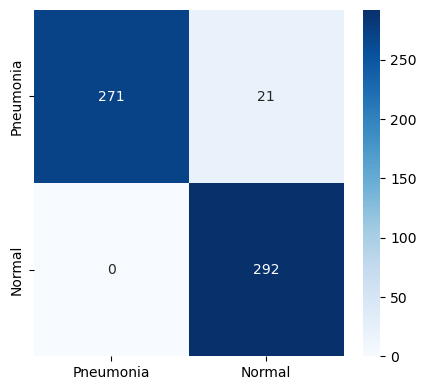

In [ ]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
df_cm = pd.DataFrame(array, index = ["Pneumonia", "Normal"],
                  columns = ["Pneumonia", "Normal"])
plt.figure(figsize = (5,4.5))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
plt.savefig('F:/sc/chest_xray/confusion.pdf')  

In [ ]:
pip install lime

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import lime
from lime import lime_image
from PIL import Image
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def xAI(model,img_dir):
    image = Image.open(img_dir)
    imgx = np.asarray(image)
    #print(imgx[:,:,0].shape)
    imgx = image.resize((224, 224))
    img = np.asarray(imgx)
    img = img/255
    img2 = np.zeros( ( np.array(img).shape[0], np.array(img).shape[1], 3 ) )
    img2[:,:,0] = img # same value in each channel
    img2[:,:,1] = img
    img2[:,:,2] = img
    #print(img2.shape)
    explainer = lime_image.LimeImageExplainer(random_state=42)
    explanation = explainer.explain_instance(img2, new_model.predict, labels=["Normal", "Pneumonia"],top_labels=2, hide_color=0,num_samples=1000)
    #plt.imshow(img)
    image, mask = explanation.get_image_and_mask(
             model.predict(img2.reshape((1,224,224,3))).argmax(axis=1)[0],
        
             positive_only=False,
        #num_features=10,
             hide_rest=False)
    plt.axis ('off')
    plt.imshow(mark_boundaries(image, mask))
    plt.savefig('F:/sc/chest_xray/lime124true.png')
    plt.savefig('F:/sc/chest_xray/lime124true.pdf')

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 222ms/step


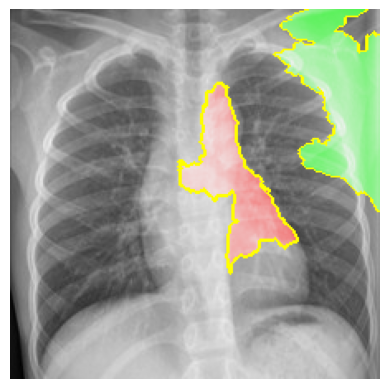

In [ ]:
#0-0
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0006-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 177ms/step


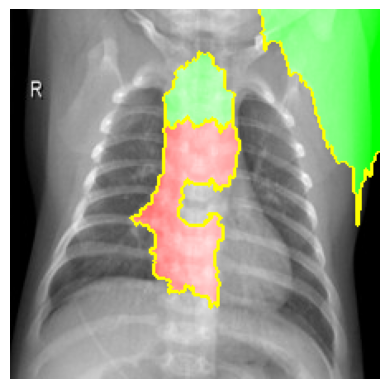

In [ ]:
#0-0
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0083-0001.jpeg")

In [ ]:
IMG_SIZE = (299, 299)
def transform_image(image_path, size):
    '''
    Function to transform an image to normalized numpy array
    '''
    img = image.load_img(image_path, target_size=size)
    img = image.img_to_array(img)# Transforming the image to get the shape as [channel, height, width]
    img = np.expand_dims(img, axis=0) # Adding dimension to convert array into a batch of size (1,299,299,3)
    img = img/255.0 # normalizing the image to keep within the range of 0.0 to 1.0
    
    return img

normalized_img = transform_image(image_path, IMG_SIZE)

NameError: name 'image_path' is not defined

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


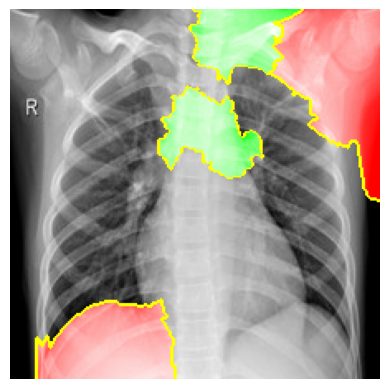

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0180-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 277ms/step


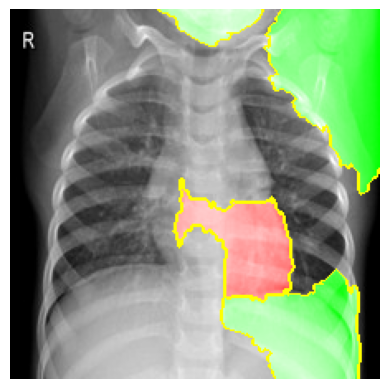

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/NORMAL/IM-0189-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 247ms/step


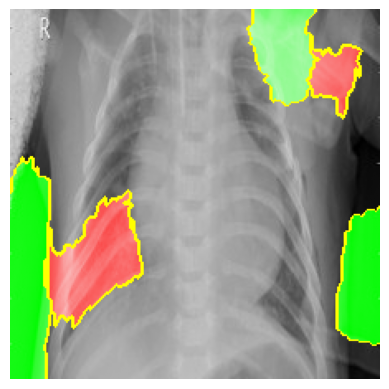

In [ ]:
#actual-1
#predict-0
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person299_bacteria_1414.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 253ms/step


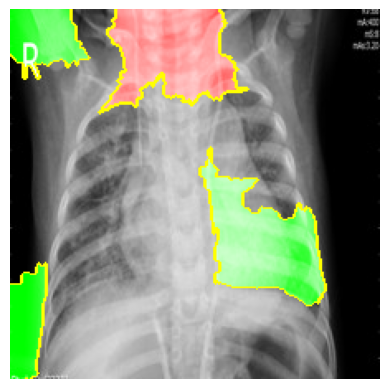

In [ ]:
#actual-1
#predict-0
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person1310_bacteria_3302.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 166ms/step


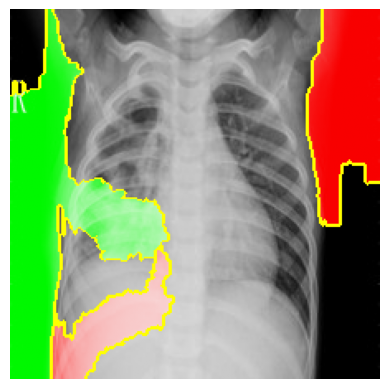

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 160ms/step


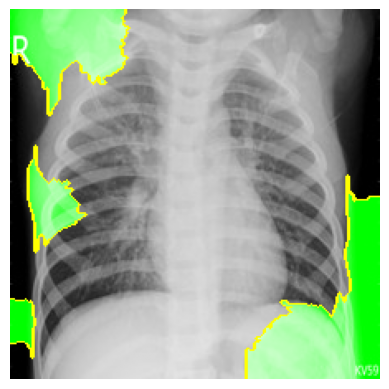

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/chest_xray/val/PNEUMONIA/person1396_virus_2399.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 162ms/step


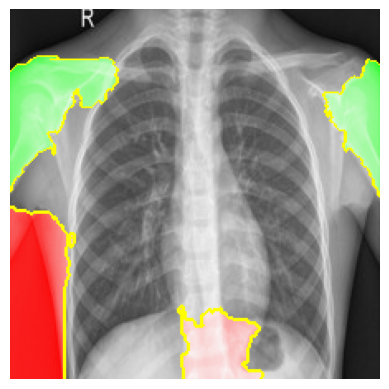

In [ ]:
#0-0
xAI(new_model, "F:/sc/chest_xray/test/NORMAL/IM-0001-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 250ms/step


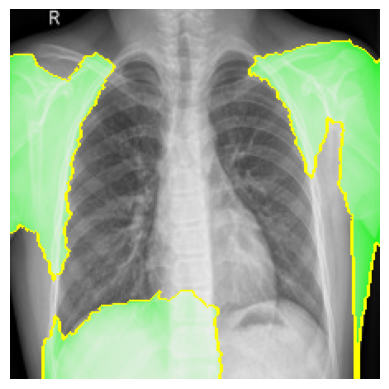

In [ ]:
#0-0
xAI(new_model, "F:/sc/chest_xray/test/NORMAL/IM-0027-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 328ms/step


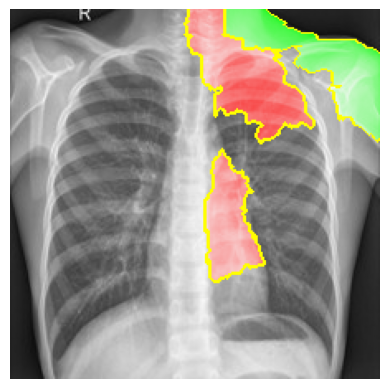

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/test/Normal/IM-0007-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 253ms/step


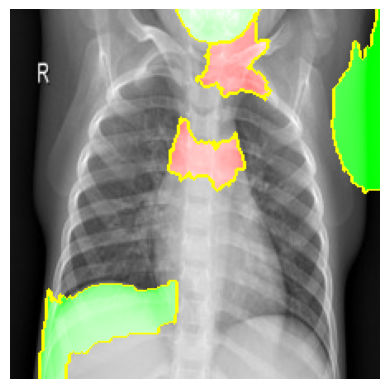

In [ ]:
#actual-0
#predict-1
xAI(new_model, "F:/sc/chest_xray/test/Normal/IM-0069-0001.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 236ms/step


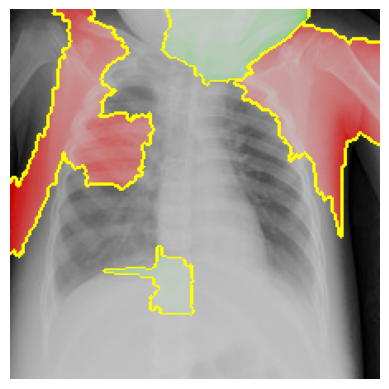

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/chest_xray/test/Pneumonia/person1682_virus_2899.jpeg")

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


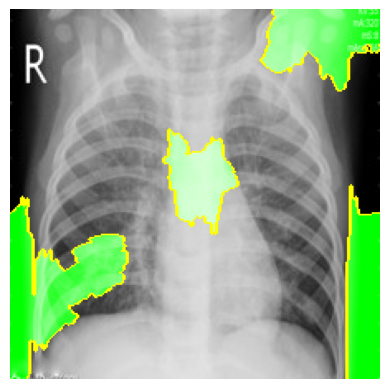

In [ ]:
#actual-1
#predict-1
xAI(new_model, "F:/sc/chest_xray/test/Pneumonia/person1673_virus_2889.jpeg")

In [ ]:
from PIL import Image
# Open the image form working directory
image = Image.open('F:/sc/chest_xray/test/PNEUMONIA/person34_virus_76.jpeg')
image = image.resize((224, 224))
# summarize some details about the image
print(image.format)
print(image.size)
print(image.mode)

data = np.asarray(image)

data = data/255

data2 = np.zeros( ( np.array(data).shape[0], np.array(data).shape[1], 3 ) )
data2[:,:,0] = data # same value in each channel
data2[:,:,1] = data
data2[:,:,2] = data
print(data2.shape)
y = new_model.predict(data2.reshape(1,224,224,3))

predicted_class_indices=np.argmax(y,axis=1)
print(predicted_class_indices)

None
(224, 224)
L
(224, 224, 3)
1/1 [==============================] - 0s 160ms/step
[1]


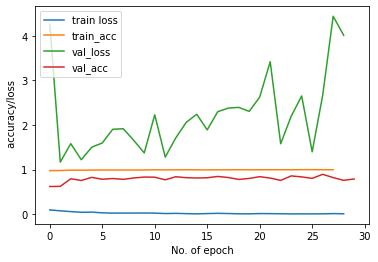

In [ ]:
import matplotlib.pyplot as plt
plt.plot([0.0962 ,0.0765 ,0.0595,0.0434 ,0.0475 ,0.0312 ,0.0252 ,0.0261 ,0.0263 ,0.0277 ,0.0246 ,0.0156 ,0.0196 ,0.0134 ,0.0086 ,0.0149 ,0.0201 ,0.0159 ,0.0096 ,0.0084 ,0.0150 ,0.0132 ,0.0112 ,0.0072 ,0.0088 ,0.0080 ,0.0093 ,0.0139 ,0.0102 ])#loss
plt.plot([0.9772 ,0.9793 ,0.9878 ,0.9868 ,0.9889 ,0.9915 ,0.9904 ,0.9908 ,0.9910 ,0.9917 ,0.9955 ,0.9936 ,0.9949 ,0.9964 ,0.9947 ,0.9932 ,0.9957 ,0.9957 ,0.9970 ,0.9955 ,0.9962 , 0.9964 ,0.9970 ,0.9962 ,0.9977 ,0.9985 ,0.9972 ,0.9966 ])#categorical_accuracy
plt.plot([4.2605 ,1.1684 ,1.5811 ,1.2213 ,1.5014 ,1.5965 ,1.9034 ,1.9152 ,1.6555 ,1.3741 ,2.2271 ,1.2801 ,1.7082 ,2.0580 ,2.2392 ,1.8899 ,2.2967 ,2.3773 ,2.3935 ,2.3047 ,2.6241 ,3.4175 ,1.5792 ,2.1961 ,2.6493 ,1.3979 ,2.6620 ,4.4353 ,4.0091 ])#val_loss
plt.plot([0.6212,0.6246,0.7952,0.7560,0.8259,0.7833,0.8003,0.7816,0.8123,0.8328,0.8294,0.7713,0.8396,0.8191,0.8123,0.8174, 0.8464,0.8225,0.7799,0.8020, 0.8413,0.8106,0.7577,0.8584,0.8362,0.8038,0.8942,0.8208,0.7594, 0.7901])#val_categorical_accuracy
#plt.title('model accuracy and loss')
plt.ylabel(' accuracy/loss')
plt.xlabel('No. of epoch')
plt.legend(['train loss','train_acc', 'val_loss','val_acc'], loc='upper left')
plt.show()

In [ ]:
loss: 0.6435 - categorical_accuracy: 0.6578 - val_loss: 4.3284 - val_categorical_accuracy: 0.5000
loss: 0.3592 - categorical_accuracy: 0.8439 - val_loss: 4.7390 - val_categorical_accuracy: 0.5000
loss: 0.3245 - categorical_accuracy: 0.8740 - val_loss: 1.9577 - val_categorical_accuracy: 0.5433
loss: 0.3080 - categorical_accuracy: 0.8802 - val_loss: 1.1540 - val_categorical_accuracy: 0.6400
loss: 0.2663 - categorical_accuracy: 0.8961 - val_loss: 0.6151 - val_categorical_accuracy: 0.8000
loss: 0.2520 - categorical_accuracy: 0.8977 - val_loss: 0.2536 - val_categorical_accuracy: 0.9067
loss: 0.2271 - categorical_accuracy: 0.9157 - val_loss: 0.2361 - val_categorical_accuracy: 0.9000
loss: 0.2131 - categorical_accuracy: 0.9245 - val_loss: 0.1594 - val_categorical_accuracy: 0.9300
loss: 0.1933 - categorical_accuracy: 0.9245 - val_loss: 0.1425 - val_categorical_accuracy: 0.9500
loss: 0.2106 - categorical_accuracy: 0.9257 - val_loss: 0.1735 - val_categorical_accuracy: 0.9267
loss: 0.1738 - categorical_accuracy: 0.9320 - val_loss: 0.1375 - val_categorical_accuracy: 0.9433
loss: 0.1721 - categorical_accuracy: 0.9378 - val_loss: 0.1329 - val_categorical_accuracy: 0.9533
loss: 0.1692 - categorical_accuracy: 0.9395 - val_loss: 0.1305 - val_categorical_accuracy: 0.9500
loss: 0.1360 - categorical_accuracy: 0.9528 - val_loss: 0.1414 - val_categorical_accuracy: 0.9467
loss: 0.1312 - categorical_accuracy: 0.9578 - val_loss: 0.1156 - val_categorical_accuracy: 0.9567
loss: 0.1544 - categorical_accuracy: 0.9462 - val_loss: 0.1109 - val_categorical_accuracy: 0.9533
loss: 0.1440 - categorical_accuracy: 0.9520 - val_loss: 0.1138 - val_categorical_accuracy: 0.9567
loss: 0.1257 - categorical_accuracy: 0.9595 - val_loss: 0.1102 - val_categorical_accuracy: 0.9567
loss: 0.1233 - categorical_accuracy: 0.9574 - val_loss: 0.0947 - val_categorical_accuracy: 0.9633
loss: 0.1101 - categorical_accuracy: 0.9620 - val_loss: 0.0968 - val_categorical_accuracy: 0.9633
loss: 0.1130 - categorical_accuracy: 0.9595 - val_loss: 0.0929 - val_categorical_accuracy: 0.9633
loss: 0.1194 - categorical_accuracy: 0.9583 - val_loss: 0.1030 - val_categorical_accuracy: 0.9533
loss: 0.0946 - categorical_accuracy: 0.9679 - val_loss: 0.0954 - val_categorical_accuracy: 0.9567
loss: 0.0888 - categorical_accuracy: 0.9708 - val_loss: 0.0853 - val_categorical_accuracy: 0.9633
loss: 0.0861 - categorical_accuracy: 0.9737 - val_loss: 0.0768 - val_categorical_accuracy: 0.9733
loss: 0.0933 - categorical_accuracy: 0.9708 - val_loss: 0.0928 - val_categorical_accuracy: 0.9667
loss: 0.0877 - categorical_accuracy: 0.9670 - val_loss: 0.0843 - val_categorical_accuracy: 0.9667
loss: 0.0805 - categorical_accuracy: 0.9708 - val_loss: 0.0717 - val_categorical_accuracy: 0.9733
loss: 0.0704 - categorical_accuracy: 0.9762 - val_loss: 0.0762 - val_categorical_accuracy: 0.9767
loss: 0.0861 - categorical_accuracy: 0.9712 - val_loss: 0.0718 - val_categorical_accuracy: 0.9700
loss: 0.0716 - categorical_accuracy: 0.9741 - val_loss: 0.0655 - val_categorical_accuracy: 0.9700

SyntaxError: invalid syntax (4062200539.py, line 1)